In [1]:
%pip install --user catboost

Note: you may need to restart the kernel to use updated packages.


### **Introduction**:

Behind every house sold is a story — of size, quality, age, and even the porch where someone once had coffee every morning.
In this notebook, we’ll uncover the hidden drivers of housing prices and build models that can predict the future of real estate.

In [2]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor

RNG = 42



### Every story starts with characters. Let’s meet ours: 1460 houses, each with 80+ features ranging from the year it was built to the slope of the land.

# Load Data

In [3]:

train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")


In [4]:
test_ids = test_df["Id"].copy()


In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)


Train shape: (1460, 81) | Test shape: (1459, 80)


### Data Cleaning 

Just like every house needs renovation, data needs cleaning.  
We check for missing values, duplicates, and strange outliers before diving deeper.  

- Are there duplicate houses?  
- Which features are missing most?  
- Are there houses with unrealistic values?  


## Check missing values & duplicates

In [11]:
# Missing values - show only columns with >0 missing (count and percentage)
na_counts = train_df.isnull().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
na_counts


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [12]:
# Remove duplicates
print("Duplicates in train:", train_df.duplicated().sum())


Duplicates in train: 0


### (EDA)

Numbers are whispers. Plots turn them into voices.  

- **Histograms:** Do prices follow a normal trend or are they skewed?  
- **Scatterplots:** How does living area shape the price?  
- **Outlier removal:** Some giant houses are sold cheap — we fix this distortion.  

## Histograms

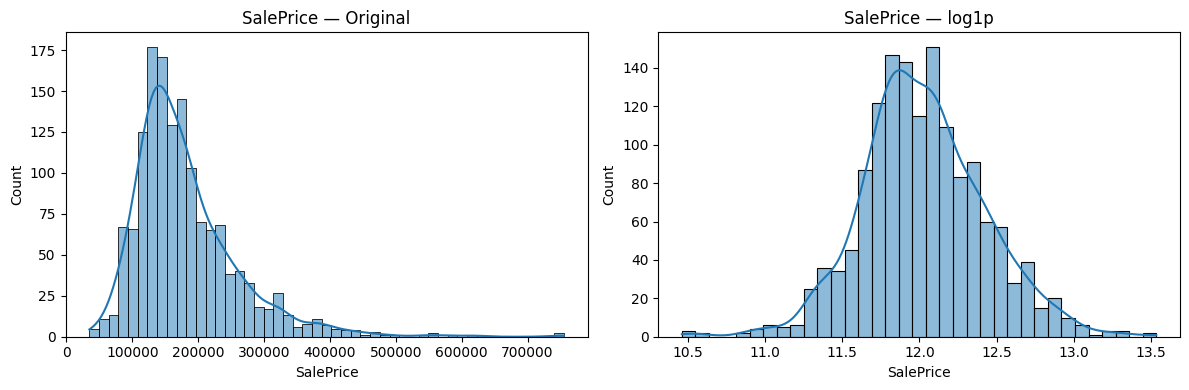

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("SalePrice — Original")

plt.subplot(1,2,2)
sns.histplot(np.log1p(train_df["SalePrice"]), kde=True)
plt.title("SalePrice — log1p")

plt.tight_layout()
plt.show()

## Scatterplot SalePrice vs GrLivArea

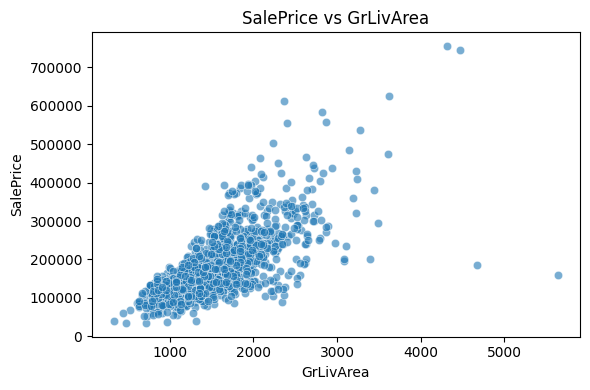

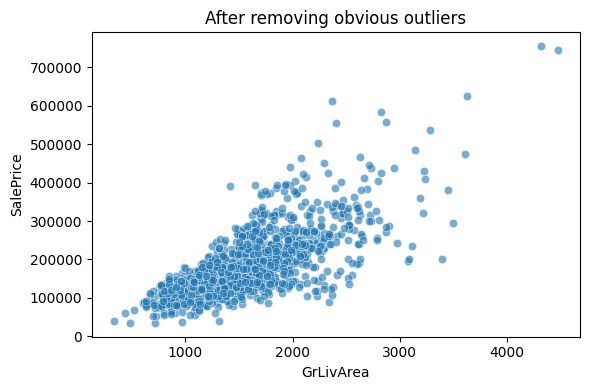

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=train_df["GrLivArea"], y=train_df["SalePrice"], alpha=0.6)
plt.xlabel("GrLivArea"); plt.ylabel("SalePrice")
plt.title("SalePrice vs GrLivArea")
plt.tight_layout()
plt.show()

#Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<500000)].index)

plt.figure(figsize=(6,4))
sns.scatterplot(x=train_df["GrLivArea"], y=train_df["SalePrice"], alpha=0.6)
plt.xlabel("GrLivArea"); plt.ylabel("SalePrice")
plt.title("After removing obvious outliers")
plt.tight_layout()
plt.show()


## Missingness top-25


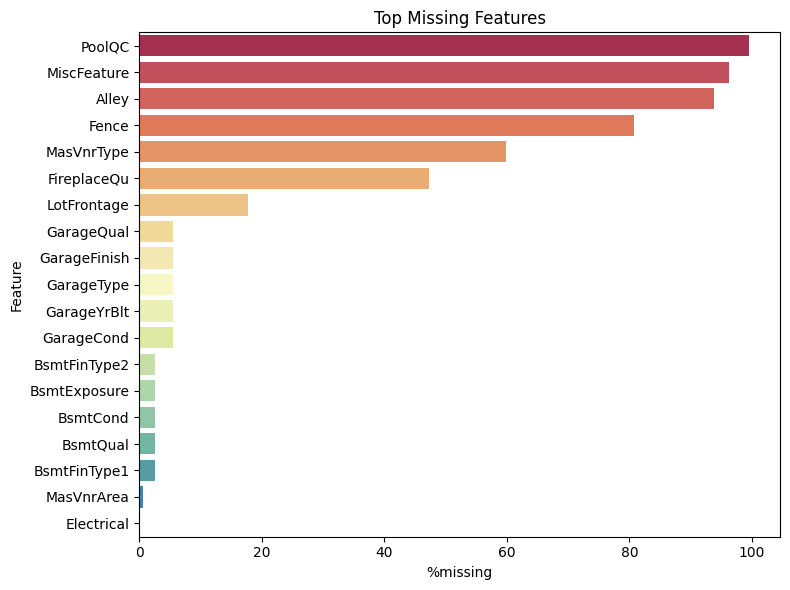

In [15]:
def plot_missing(train_df, top=25):
    na = (train_df.isna().sum()/len(train_df)).sort_values(ascending=False)
    na = na[na>0].head(top)
    if len(na) > 0:
        plt.figure(figsize=(8,6))
        sns.barplot(x=na.values*100, y=na.index, palette= 'Spectral')
        plt.xlabel("%missing")
        plt.ylabel("Feature")
        plt.title("Top Missing Features")
        plt.tight_layout()
        plt.show() 
plot_missing(train_df)

In [16]:
train_df['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

## Q-Q plot

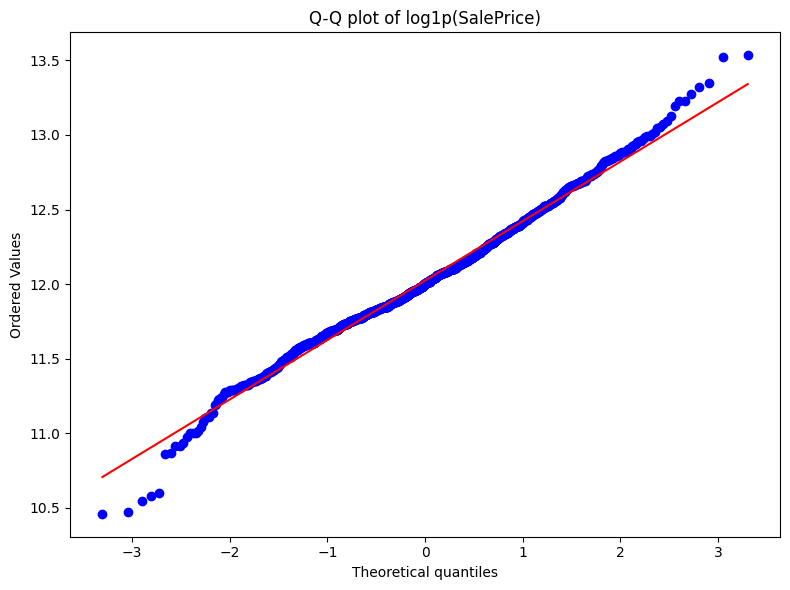

In [17]:
from scipy import stats
plt.figure(figsize=(8,6))
stats.probplot(np.log1p(train_df["SalePrice"]),dist='norm', plot=plt)
plt.title('Q-Q plot of log1p(SalePrice)')
plt.tight_layout()
plt.show()

## Barplot 

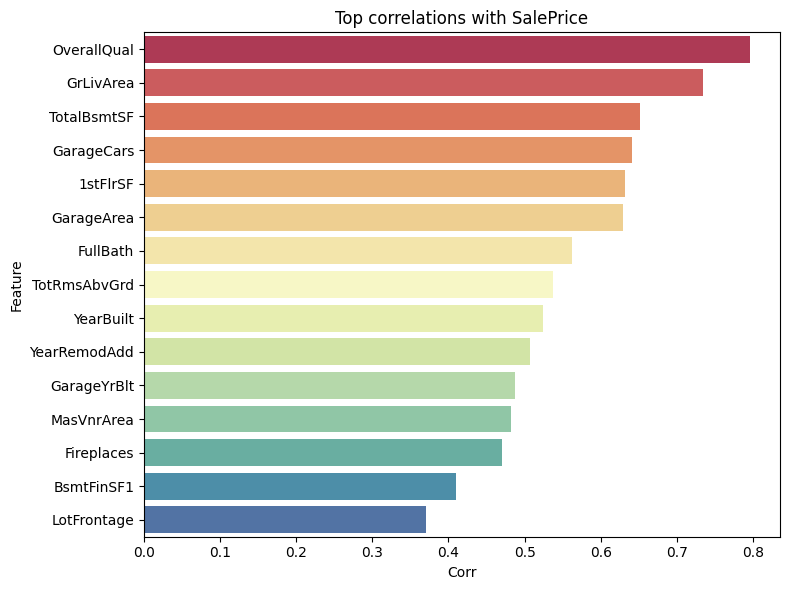

In [18]:
num_cols = train_df.select_dtypes(include=np.number).columns
corr_target = train_df[num_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
top_corr = corr_target.iloc[1:16]
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values , y=top_corr.index, palette= 'Spectral')
plt.title('Top correlations with SalePrice')
plt.xlabel("Corr")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Price vs YearBuilt

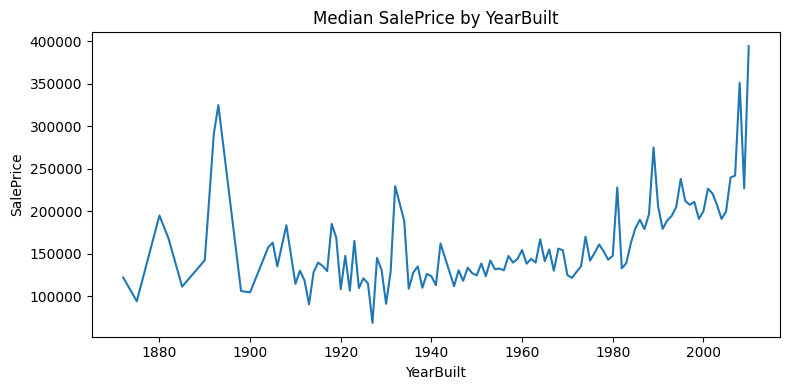

In [19]:
year_price = train_df.groupby("YearBuilt")["SalePrice"].median().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(data=year_price, x="YearBuilt", y="SalePrice")
plt.title("Median SalePrice by YearBuilt"); plt.tight_layout(); plt.show()


## Boxplot 

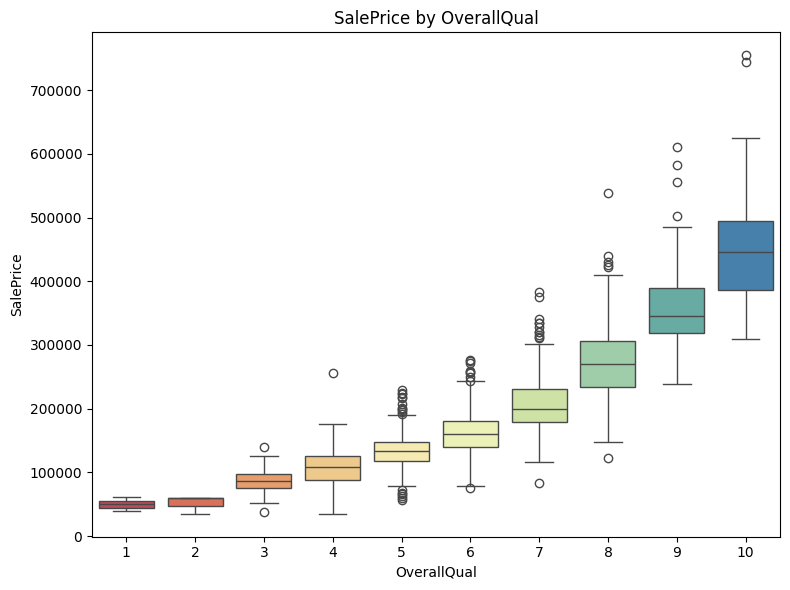

In [20]:
plt.figure(figsize=(8,6))
sns.boxplot(data=train_df, x='OverallQual', y='SalePrice', palette= 'Spectral')
plt.title('SalePrice by OverallQual')
plt.tight_layout()
plt.show()

In [21]:
def drop_id(df):
    return df.drop(columns=["Id"], errors="ignore")

train_df = drop_id(train_df)
test_df  = drop_id(test_df)

### Feature Engineering

A house is more than its walls. Let’s create new features:  

- **Age & Remodeling:** Old vs New homes.  
- **Total Space & Bathrooms:** Because size matters.  
- **Porches, Garages, Pools:** Outdoor luxury counts too.  
- **Flags (HasGarage, HasFireplace…):** Tiny details that make a big difference.  


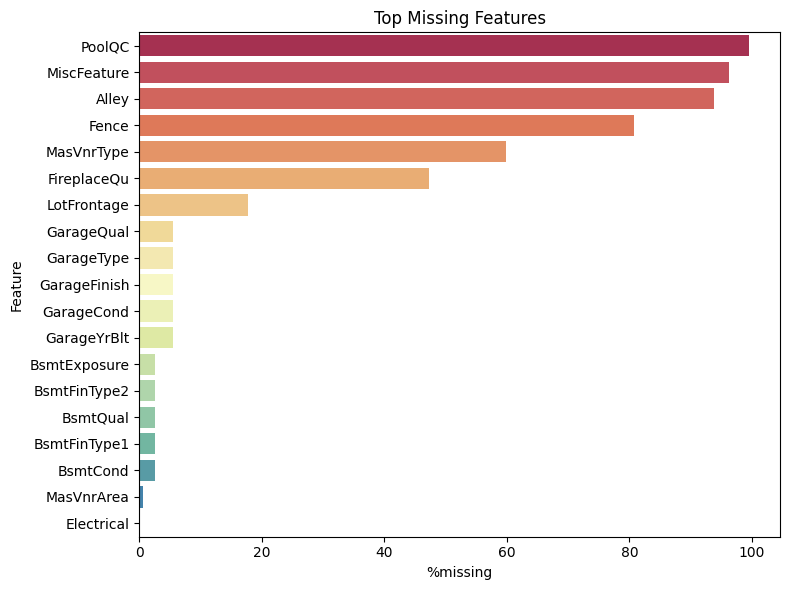

In [22]:
def plot_missing(train_df, top=25):
    na = (train_df.isna().sum()/len(train_df)).sort_values(ascending=False)
    na = na[na>0].head(top)
    if len(na) > 0:
        plt.figure(figsize=(8,6))
        sns.barplot(x=na.values*100, y=na.index, palette= 'Spectral')
        plt.xlabel("%missing")
        plt.ylabel("Feature")
        plt.title("Top Missing Features")
        plt.tight_layout()
        plt.show() 
plot_missing(train_df)

In [23]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    for c in [
        "YrSold","YearBuilt","YearRemodAdd","1stFlrSF","2ndFlrSF","TotalBsmtSF",
        "FullBath","HalfBath","BsmtFullBath","BsmtHalfBath",
        "OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch",
        "GarageArea","GarageCars","GrLivArea","LotArea","Fireplaces","PoolArea",
        "WoodDeckSF","TotRmsAbvGrd","BedroomAbvGr","MasVnrArea","GarageYrBlt",
        "BsmtFinSF1","LotFrontage","OverallCond"
    ]:
        if c not in d:
            d[c] = 0
    # Ages        
    d["Age"] = (d['YrSold'] - d["YearBuilt"]).clip(lower=0)
    d["SinceRemodel"] = (d["YrSold"] - d["YearRemodAdd"]).clip(lower=0)
    d['IsRemodeled'] = (d["YearRemodAdd"] != d["YearBuilt"]).astype(int)
    d["IsNew"] = (d["YearBuilt"] >= (d["YrSold"] - 1)).astype(int)
    d["GarageAge"] = (d["YrSold"] - d['GarageYrBlt']).clip(lower=0)
    
    # Areas & ratios
    d["TotalSF"] = d[["TotalBsmtSF","1stFlrSF","2ndFlrSF"]].fillna(0).sum(axis=1)
    d["LivingPerRoom"] = (d['GrLivArea'] /d["TotRmsAbvGrd"].replace(0,np.nan)).fillna(0)
    d["LotRatio"] = (d['GrLivArea'] / d["LotArea"].replace(0, np.nan)).fillna(0)
    d["PorchArea"] = d[["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]].fillna(0).sum(axis=1)
    d["TotalOutdoor"] = d["PorchArea"] + d["WoodDeckSF"].fillna(0) + d["PoolArea"].fillna(0)   
    
    # Baths
    d["TotalBaths"] = (d["FullBath"].fillna(0) + 0.5*d['HalfBath'].fillna(0) + d["BsmtFullBath"].fillna(0) + 0.5*d["BsmtHalfBath"].fillna(0))
    d["BathPerBedroom"] = (d["TotalBaths"] / d["BedroomAbvGr"].replace(0, np.nan)).fillna(0)
    
    # Flags
    d["HasBsmt"]      = (d["TotalBsmtSF"].fillna(0) > 0).astype(int)
    d["HasGarage"]    = (d["GarageArea"].fillna(0) > 0).astype(int)
    d["Has2ndFl"]     = (d["2ndFlrSF"].fillna(0) > 0).astype(int)
    d["HasFireplace"] = (d["Fireplaces"].fillna(0) > 0).astype(int)
    d["HasPool"]      = (d["PoolArea"].fillna(0) > 0).astype(int)
    
    # Location
        
    d["IsCornerLot"] = (d["LotConfig"] == "Corner").astype(int)
    d["LandSlopeFlag"] = (d["LandSlope"] != "Gtl").astype(int)
    
    # Features 
    if "OverallQual" in d.columns and "OverallCond" in d.columns:
        d["OverallScore"] = d["OverallQual"] * d["OverallCond"]
    d["GarageCapacityRatio"] = (d["GarageCars"] / d["TotRmsAbvGrd"].replace(0, np.nan)).fillna(0)
    
    # Simple interactions     
    if "SalePrice" in d.columns:
        d["LogSalePrice"] = np.log1p(d["SalePrice"]) 
    d["LogLotArea"] = np.log1p(d["LotArea"])
    d["GrLivArea2"]   = d["GrLivArea"]**2
    d["Qual_Age"]     = d["OverallQual"] * d["Age"]
    
    return d

In [24]:
df_eda = add_features(train_df.drop(columns=["SalePrice"]))
df_eda = df_eda.assign(SalePrice=train_df["SalePrice"].values)


## Regplots

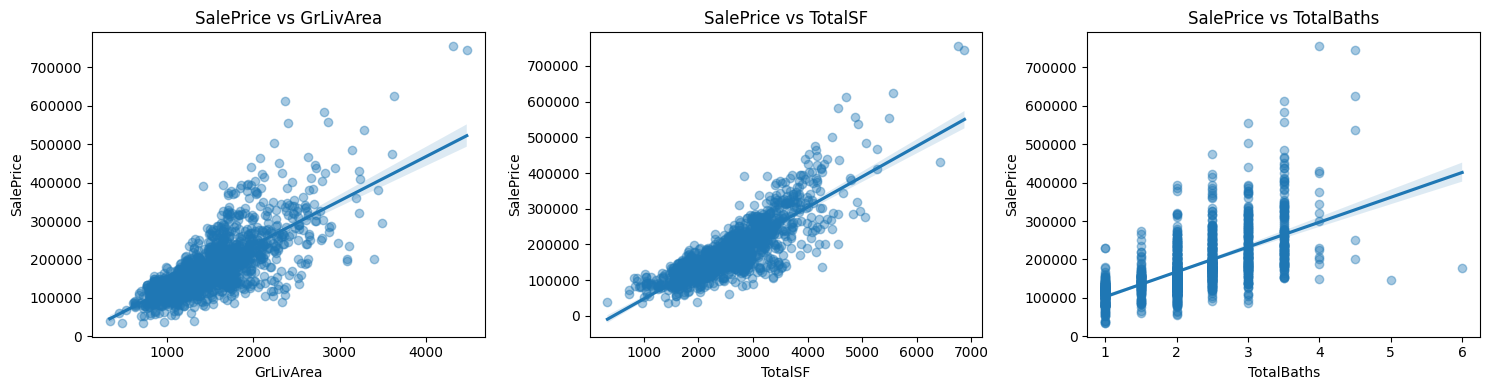

In [25]:
features = ["GrLivArea" , "TotalSF", "TotalBaths"]
fig , axes = plt.subplots(1 , len(features), figsize=(5*len(features), 4))
for i, col in enumerate(features):
    sns.regplot(
        data=df_eda, x=col , y="SalePrice",
        ax=axes[i], scatter_kws={"alpha": 0.4}
    )
    axes[i].set_title(f"SalePrice vs {col}")
plt.tight_layout()
plt.show()

## High Price of Neighborhood & Boxplot

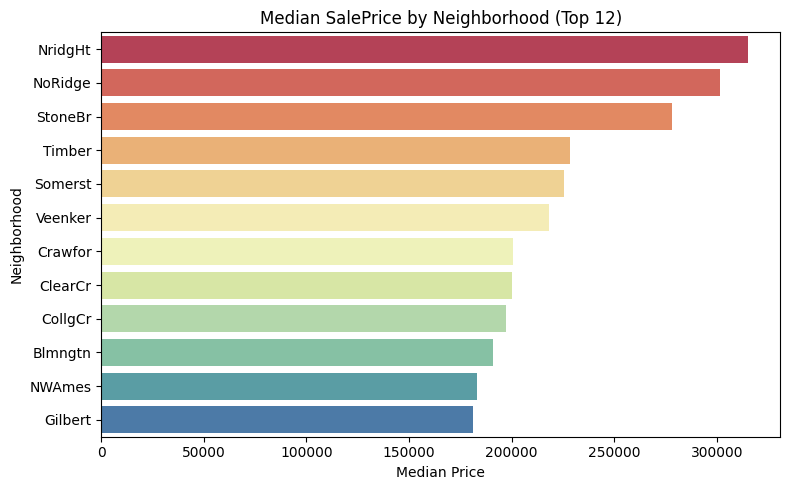

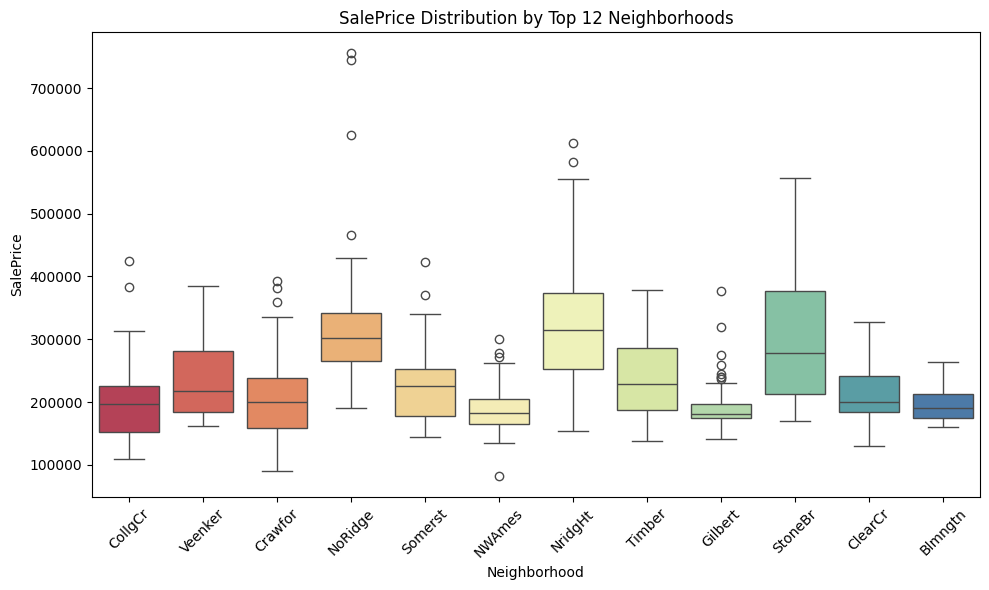

In [26]:
nbh = train_df.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False).head(12)
plt.figure(figsize=(8,5))
sns.barplot(x=nbh.values, y=nbh.index, palette= 'Spectral')
plt.title("Median SalePrice by Neighborhood (Top 12)")
plt.xlabel("Median Price"); plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

top12 = nbh.index
plt.figure(figsize=(10,6))
sns.boxplot(
    data=train_df[train_df["Neighborhood"].isin(top12)],
    x="Neighborhood", y="SalePrice", palette= 'Spectral'
)
plt.xticks(rotation=45)
plt.title("SalePrice Distribution by Top 12 Neighborhoods")
plt.tight_layout()
plt.show()


## Target mean plots

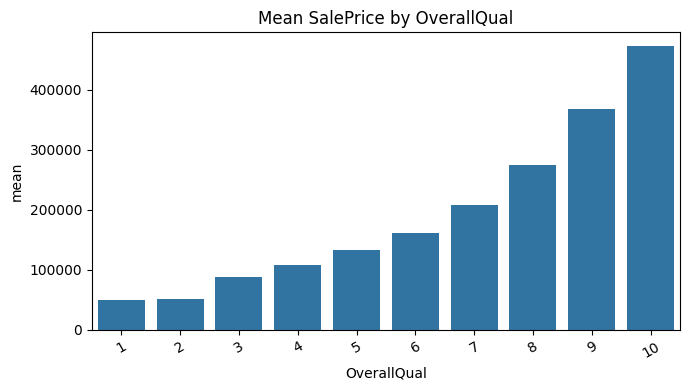

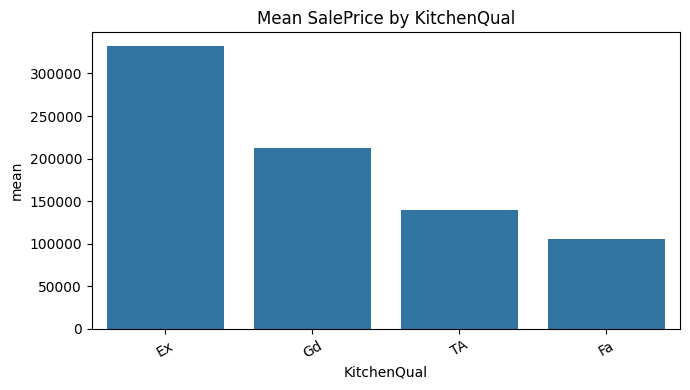

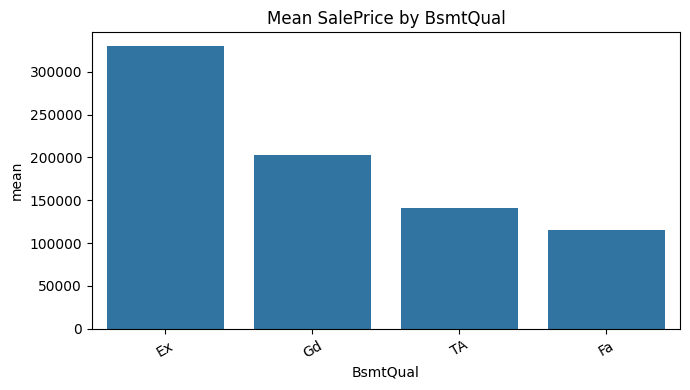

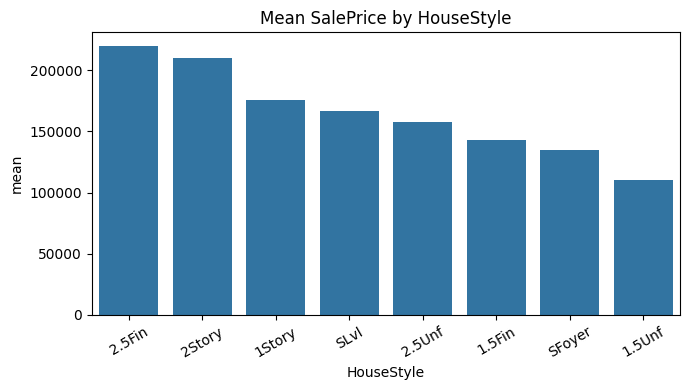

In [27]:
cat_cols = ["OverallQual","KitchenQual","BsmtQual","HouseStyle"]

for col in [col for col in cat_cols if col in train_df.columns]:
    g = (train_df.groupby(col)["SalePrice"]
         .agg(["mean","count"]).reset_index().sort_values("mean", ascending=False))
    plt.figure(figsize=(7,4))
    sns.barplot(data=g, x=col, y="mean")
    plt.title(f"Mean SalePrice by {col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


###  Heatmap & Pairplot — The Social Network of Features  

Like a city's social map, features interact with each other:  

- **Heatmap:** Correlation web of space, quality, and age.  
- **Pairplot:** A family portrait of key variables alongside SalePrice.  


## Heatmap 

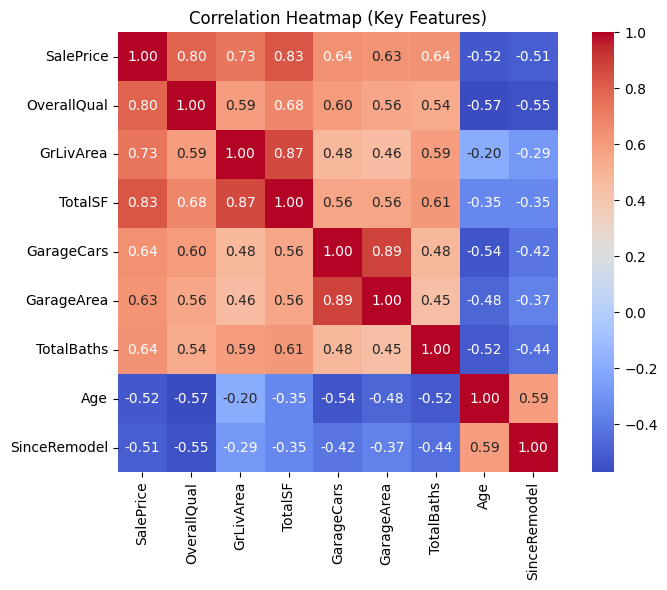

In [28]:
cols = [c for c in ["SalePrice","OverallQual","GrLivArea","TotalSF","GarageCars","GarageArea",
                        "TotalBaths","Age","SinceRemodel"] 
        if c in df_eda.columns or c=="SalePrice"]

plt.figure(figsize=(8,6))
sns.heatmap(df_eda[cols].corr(), annot=True , fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Key Features)")
plt.tight_layout()
plt.show()

## Pairplots

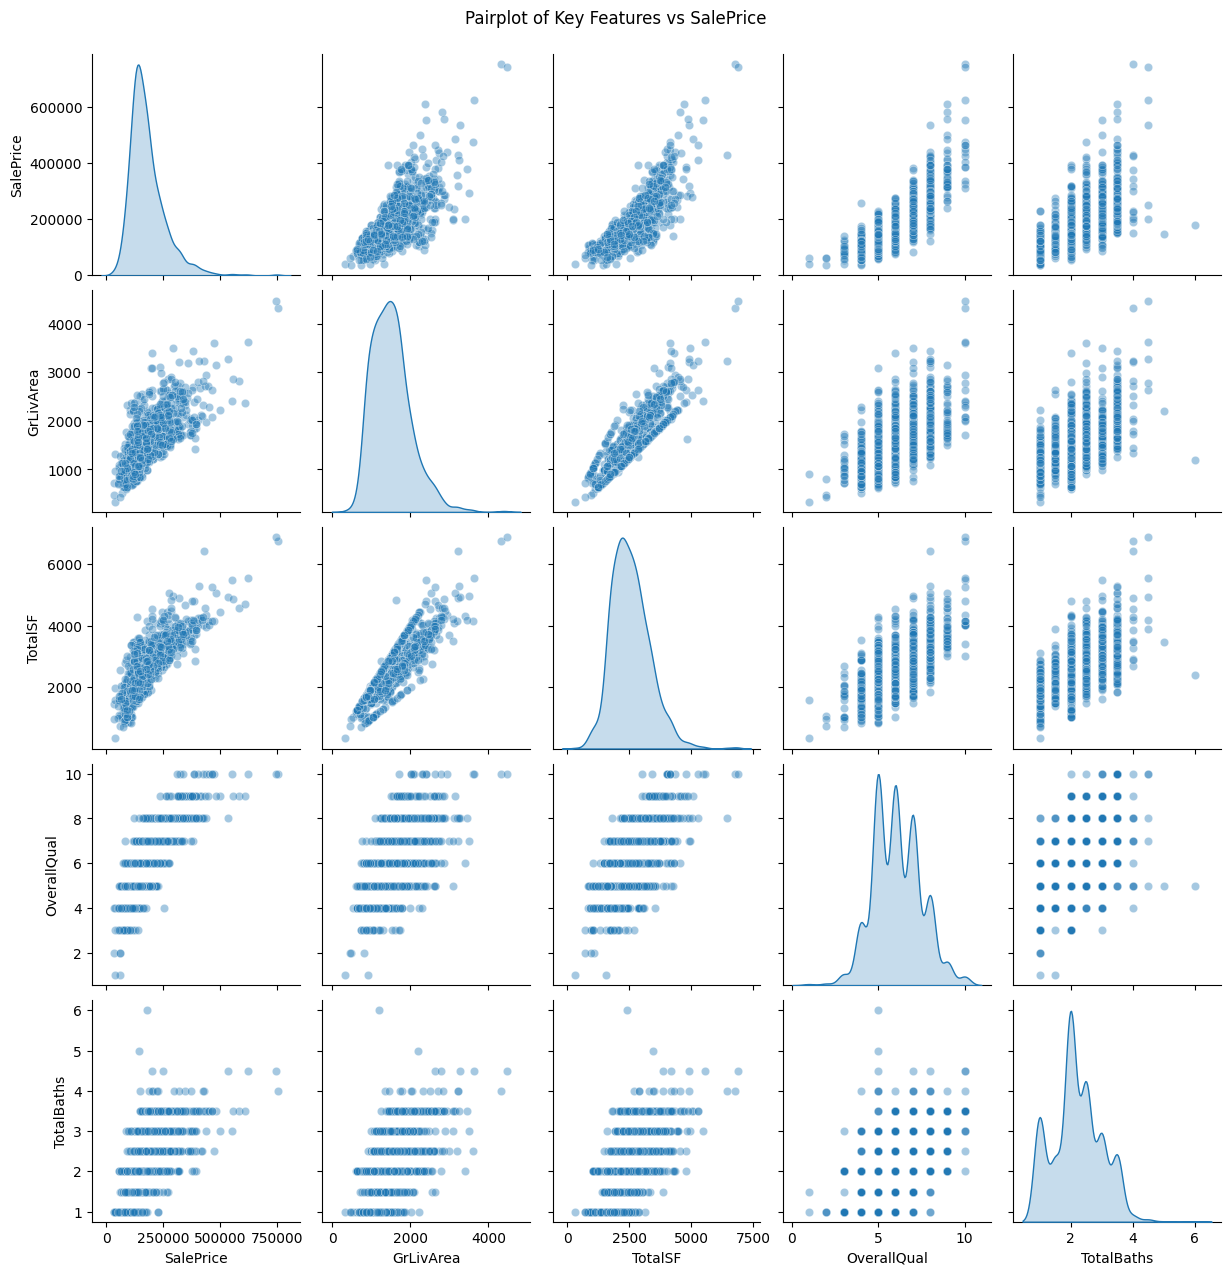

In [29]:
pair_features = ["SalePrice", "GrLivArea", "TotalSF", "OverallQual", "TotalBaths"]
sns.pairplot(df_eda[pair_features], diag_kind="kde", plot_kws={"alpha":0.4})
plt.suptitle("Pairplot of Key Features vs SalePrice", y=1.02)
plt.show()


## Preparing modeling data

In [30]:
X = train_df.drop('SalePrice', axis = 1)
y = train_df['SalePrice'].values

X_fe = add_features(X)
test_fe = add_features(test_df)


print("Train After FE:", X_fe.shape, "Test After FE:", test_fe.shape)

Train After FE: (1458, 103) Test After FE: (1459, 103)


In [31]:
if "Neighborhood" in X_fe.columns:
    neigh_median = train_df.groupby("Neighborhood")["SalePrice"].median()
    X_fe["NeighborhoodMedianPrice"]    = X_fe["Neighborhood"].map(neigh_median).fillna(neigh_median.median())
    test_fe["NeighborhoodMedianPrice"] = test_fe["Neighborhood"].map(neigh_median).fillna(neigh_median.median())


## Preprocessing: Impute + Scale + OHE

In [32]:
num_pipe = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("Scaler", StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse_output=False)
except TypeError:  
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
preprocessor = ColumnTransformer([
  ("num", num_pipe, selector(dtype_include=np.number)),
  ("cat", cat_pipe, selector(dtype_include=object))
])


## CV with RMSLE (10-Fold)

In [33]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0) 
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

models = {
    "Ridge": Ridge(alpha=20),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=RNG, n_jobs=-1),
    "XGBoost": XGBRegressor(                
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RNG,
        n_jobs=-1
    ),
        "CatBoost": CatBoostRegressor(  
        n_estimators=1500,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        random_seed=RNG,
        verbose=False
    )
}


cv = KFold(n_splits=10, shuffle=True, random_state=RNG)

rows = []
for name, est in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", est)])
    n_jobs_cv = 1 if name == "CatBoost" else -1
    scores = cross_val_score(pipe, X_fe, y, scoring=rmsle_scorer, cv=cv, n_jobs=n_jobs_cv)
    rows.append([name, -scores.mean(), scores.std()])

cv_table = pd.DataFrame(rows, columns=["Model","CV_RMSLE (↓)","STD"]).sort_values("CV_RMSLE (↓)").reset_index(drop=True)
print("\n=== CV Leaderboard (10-Fold, lower is better) ===")
print(cv_table.to_string(index=False))

best_name = cv_table.iloc[0]["Model"]
best_est  = models[best_name]
print(f"\n>>> Best model: {best_name}")



=== CV Leaderboard (10-Fold, lower is better) ===
       Model  CV_RMSLE (↓)      STD
    CatBoost      0.109380 0.013913
     XGBoost      0.114092 0.012413
       Ridge      0.124286 0.015872
RandomForest      0.130627 0.012751

>>> Best model: CatBoost


As expected, CatBoost dominates

###  CV Leaderboard (10-Fold, RMSLE ↓)

| Model        | CV_RMSLE (↓) | STD     |
|--------------|--------------|---------|
| **CatBoost** | **0.109380** | 0.013913 |
| XGBoost      | 0.114092     | 0.012413 |
| Ridge        | 0.124286     | 0.015872 |
| RandomForest | 0.130627     | 0.012751 |


## final_pipe → fit → predict

In [34]:
final_pipe = Pipeline([("prep", preprocessor), ("model", best_est)])
final_pipe.fit(X_fe, y)

preds = final_pipe.predict(test_fe)
preds = np.maximum(preds, 0)
print("Test predictions:", preds[:10])


Test predictions: [124867.57796673 162922.11225876 182937.40763462 195240.44845998
 179621.35285912 174642.35839865 179351.2838441  169269.42715826
 186003.19969127 124611.89493351]


### Error Analysis



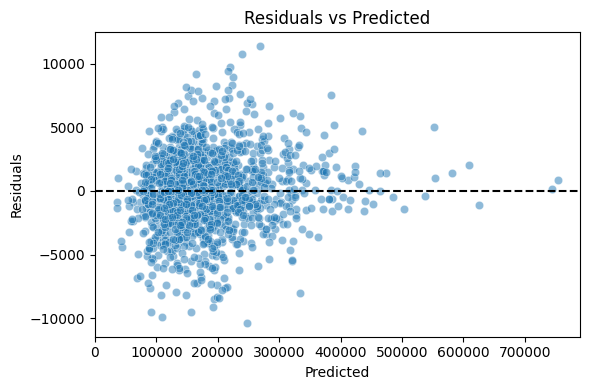

In [35]:
try:
    y_pred_train = np.maximum(final_pipe.predict(X_fe), 0)
    residuals = y - y_pred_train
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred_train, y=residuals, alpha=0.5)
    plt.axhline(0, ls="--", c="k")
    plt.title("Residuals vs Predicted"); plt.xlabel("Predicted"); plt.ylabel("Residuals")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[Info] Skipped residuals:", e)


### Residuals show more spread for cheaper houses, suggesting these are harder to model. Feature engineering around quality/condition may reduce this variance.

# Submission

In [36]:
submission = pd.DataFrame({"Id": test_ids, "SalePrice": preds})
submission.to_csv("submission.csv", index=False)
print("\nSaved: submission.csv")
display(submission.head())


Saved: submission.csv


,Id,SalePrice
0,1461,124867.577967
1,1462,162922.112259
2,1463,182937.407635
3,1464,195240.448460
4,1465,179621.352859
